In [1]:

import torch
import networkx as nx
import torch_geometric
from torch_geometric.data import Data
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Prepare graph data
def dyadic_noisy_wavelet_graph(betahat, sebathat):
    """
    Build a dyadic graph from wavelet decomposition coefficients.
    Each node at level n is connected to two nodes at level n+1.
    Add coefficient indices for detailed representation.
    """
    max_length = max(len(c) for c in betahat)  # Determine max length of coefficient arrays
    node_features = []  # To store node features
    edges = []  # To store edges
    node_labels = {}  # To label nodes for visualization
    node_levels = {}  # To store levels for layout
    node_coefficients = {}  # To store wavelet coefficients for color mapping

    current_node = 0  # Node counter

    # Add root node (original signal approximation)
    root_feature = np.pad(betahat[0], (0, max_length - len(betahat[0])), mode='constant')
    node_features.append(root_feature.tolist())
    node_labels[current_node] = "Root (s,0)"
    node_levels[current_node] = 0
    node_coefficients[current_node] = betahat[0][0]  # Use the first coefficient of the root

    parent_nodes = [current_node]  # Track parent nodes for dyadic connections
    current_node += 1

    # Process detail coefficients for wavelet levels
    for level, c in enumerate(betahat[1:], start=1):
        new_parent_nodes = []  # Track new parent nodes for the next level
        for parent in parent_nodes:
            # Each parent connects to two children
            for i in range(2):
                if len(c) > 2 * (parent - parent_nodes[0]) + i:  # Check if index is within bounds
                    coeff_index = 2 * (parent - parent_nodes[0]) + i
                    padded_feature = np.pad([c[coeff_index]],
                                            (0, max_length - 1), mode='constant')
                    node_features.append(padded_feature.tolist())
                    s_or_l = "s" if i == 0 else "l"  # Determine short (s) or long (l) connection
                    node_labels[current_node] = f"Level {level} ({s_or_l},{coeff_index})"
                    node_levels[current_node] = level
                    node_coefficients[current_node] = c[coeff_index]  # Store wavelet coefficient
                    edges.append([parent, current_node])  # Add edge
                    new_parent_nodes.append(current_node)
                    current_node += 1
        parent_nodes = new_parent_nodes  # Update parent nodes for next level

    # Convert to PyTorch tensors
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index), node_labels, node_levels, node_coefficients

# Draw the graph with improved visualization
def draw_dyadic_wavelet_graph_pyramid(g, node_labels, node_levels, node_coefficients):
    plt.figure(figsize=(12, 8))
    for node, level in node_levels.items():
        g.nodes[node]['subset'] = level  # Add subset information for each node
    pos = nx.multipartite_layout(g, subset_key='subset')  # Arrange in levels

    # Normalize coefficients for color mapping
    coeff_values = list(node_coefficients.values())
    norm = mcolors.Normalize(vmin=min(coeff_values), vmax=max(coeff_values))
    cmap = plt.cm.RdBu_r  # Red for positive, blue for negative

    node_colors = [cmap(norm(node_coefficients[node])) for node in g.nodes()]

    nx.draw(
        g, pos, with_labels=True, labels=node_labels,
        node_size=(70), node_color=node_colors, font_size=2, font_weight="bold", edge_color="gray"
    )
    plt.gca().invert_yaxis()  # Invert Y-axis for top-down pyramid
    plt.title("Dyadic Wavelet Graph Pyramid Visualization with Coefficients", fontsize=14)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(coeff_values) 
    plt.show()

In [2]:
import numpy as np
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def dyadic_noisy_wavelet_graph(betahat, sebetahat):
    """
    Build a dyadic graph from wavelet decomposition coefficients, including noise information.
    Each node at level n is connected to two nodes at level n+1.
    Add coefficient indices and noise for detailed representation.
    """
    max_length = max(len(c) for c in betahat)  # Determine max length of coefficient arrays
    node_features = []  # To store node features (coefficients and noise)
    edges = []  # To store edges
    node_labels = {}  # To label nodes for visualization
    node_levels = {}  # To store levels for layout
    node_coefficients = {}  # To store wavelet coefficients for color mapping

    current_node = 0  # Node counter

    # Add root node (original signal approximation)
    root_feature = np.pad(betahat[0], (0, max_length - len(betahat[0])), mode='constant')
    root_noise = np.pad(sebetahat[0], (0, max_length - len(sebetahat[0])), mode='constant')
    node_features.append(np.concatenate((root_feature, root_noise)).tolist())
    node_labels[current_node] = "Root (s,0)"
    node_levels[current_node] = 0
    node_coefficients[current_node] = betahat[0][0]  # Use the first coefficient of the root

    parent_nodes = [current_node]  # Track parent nodes for dyadic connections
    current_node += 1

    # Process detail coefficients for wavelet levels
    for level, (c, n) in enumerate(zip(betahat[1:], sebetahat[1:]), start=1):
        new_parent_nodes = []  # Track new parent nodes for the next level
        for parent in parent_nodes:
            # Each parent connects to two children
            for i in range(2):
                if len(c) > 2 * (parent - parent_nodes[0]) + i:  # Check if index is within bounds
                    coeff_index = 2 * (parent - parent_nodes[0]) + i
                    padded_coeff = np.pad([c[coeff_index]], (0, max_length - 1), mode='constant')
                    padded_noise = np.pad([n[coeff_index]], (0, max_length - 1), mode='constant')
                    node_features.append(np.concatenate((padded_coeff, padded_noise)).tolist())
                    s_or_l = "s" if i == 0 else "l"  # Determine short (s) or long (l) connection
                    node_labels[current_node] = f"Level {level} ({s_or_l},{coeff_index})"
                    node_levels[current_node] = level
                    node_coefficients[current_node] = c[coeff_index]  # Store wavelet coefficient
                    edges.append([parent, current_node])  # Add edge
                    new_parent_nodes.append(current_node)
                    current_node += 1
        parent_nodes = new_parent_nodes  # Update parent nodes for next level

    # Convert to PyTorch tensors
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index), node_labels, node_levels, node_coefficients

def draw_dyadic_wavelet_graph_pyramid(g, node_labels, node_levels, node_coefficients):
    plt.figure(figsize=(12, 8))
    for node, level in node_levels.items():
        g.nodes[node]['subset'] = level  # Add subset information for each node
    pos = nx.multipartite_layout(g, subset_key='subset')  # Arrange in levels

    # Normalize coefficients for color mapping
    coeff_values = list(node_coefficients.values())
    norm = mcolors.Normalize(vmin=min(coeff_values), vmax=max(coeff_values))
    cmap = plt.cm.RdBu_r  # Red for positive, blue for negative

    node_colors = [cmap(norm(node_coefficients[node])) for node in g.nodes()]

    nx.draw(
        g, pos, with_labels=True, labels=node_labels,
        node_size=(70), node_color=node_colors, font_size=2, font_weight="bold", edge_color="gray"
    )
    plt.gca().invert_yaxis()  # Invert Y-axis for top-down pyramid
    plt.title("Dyadic Wavelet Graph Pyramid Visualization with Coefficients", fontsize=14)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(coeff_values) 
    plt.colorbar(sm, label="Wavelet Coefficients")
    plt.show()


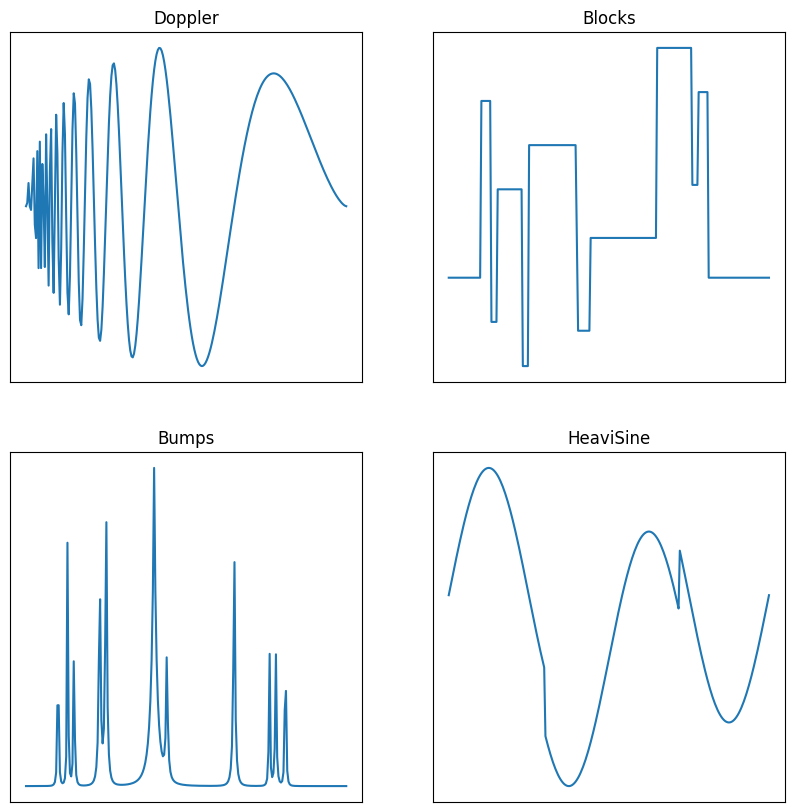

In [3]:
import torch
import networkx as nx
import torch_geometric
from torch_geometric.data import Data
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
def doppler(x):
    """
    Parameters
    ----------
    x : array-like
        Domain of x is in (0,1]
 
    """
    if not np.all((x >= 0) & (x <= 1)):
        raise ValueError("Domain of doppler is x in (0,1]")
    return np.sqrt(x*(1-x))*np.sin((2.1*np.pi)/(x+.05))
 
def blocks(x):
    """
    Piecewise constant function with jumps at t.
 
    Constant scaler is not present in Donoho and Johnstone.
    """
    K = lambda x : (1 + np.sign(x))/2.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2]]).T
    return 3.655606 * np.sum(h*K(x-t), axis=0)
 
def bumps(x):
    """
    A sum of bumps with locations t at the same places as jumps in blocks.
    The heights h and widths s vary and the individual bumps are of the
    form K(t) = 1/(1+|x|)**4
    """
    K = lambda x : (1. + np.abs(x)) ** -4.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, 5, 3, 4, 5, 4.2, 2.1, 4.3, 3.1, 2.1, 4.2]]).T
    w = np.array([[.005, .005, .006, .01, .01, .03, .01, .01, .005, .008, .005]]).T
    return np.sum(h*K((x-t)/w), axis=0)
 
def heavisine(x):
    """
    Sinusoid of period 1 with two jumps at t = .3 and .72
    """
    return 4 * np.sin(4*np.pi*x) - np.sign(x - .3) - np.sign(.72 - x)
     

x = np.linspace(0,1,2**8)
dop = doppler(x)
blk = blocks(x)
bmp = bumps(x)
hsin = heavisine(x)
fig, axes = plt.subplots(2, 2, figsize=(10,10))
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

ax1.plot(x,dop)
ax1.set_title("Doppler")

ax2.plot(x,blk)
ax2.set_title("Blocks")

ax3.plot(x,bmp)
ax3.set_title("Bumps")

ax4.set_title("HeaviSine")
ax4.plot(x,hsin)

for ax in fig.axes:
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, 
                   top=False, left=False, right=False)     


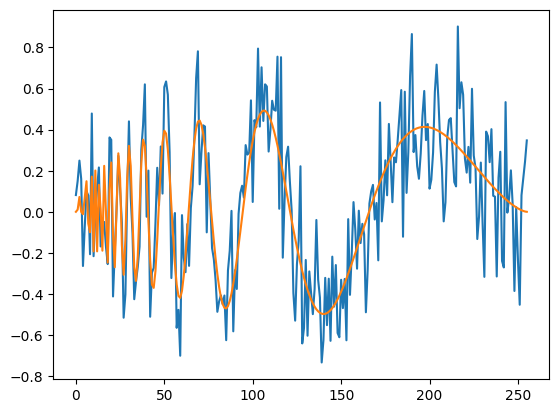

In [4]:
# Generate a sample signal
sd_noise=0.2
signal = doppler (x) + np.random.normal(0, sd_noise,x.shape)
plt.plot(signal)
plt.plot(doppler (x))
# Perform wavelet decomposition
wavelet = 'db1'
coeffs = pywt.wavedec(signal, wavelet )
coeffs_true = pywt.wavedec(doppler (x), wavelet )

In [5]:
np.var(coeffs[2]-coeffs_true[2 ])

np.float64(0.0035380551539229764)

In [6]:
betahat =coeffs
sebetahat = [np.full_like(arr,sd_noise) for arr in betahat]
#formating sebetahat correctly

In [7]:
num_classes = 20

import os
import sys
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *
 
scale = autoselect_scales_mix_norm(betahat=np.concatenate(betahat),
                                   sebetahat=np.concatenate(sebetahat),
                                       max_class=num_classes ) 

In [8]:
scale

array([0.        , 0.23004953, 0.46009907, 0.6901486 , 0.92019814,
       1.15024767, 1.38029721, 1.61034674, 1.84039628, 2.07044581,
       2.30049535, 2.53054488, 2.76059441, 2.99064395, 3.22069348,
       3.45074302, 3.68079255, 3.91084209, 4.14089162, 4.37094116])

In [9]:
import numpy as np
import pywt
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv

# Function to compute noise levels in the wavelet domain
def compute_wavelet_noise_levels(signal_length, sigma0, wavelet_name='db1', decomposition_level=None):
    """
    Compute the noise level in the wavelet domain given an input noise level in the original domain.

    Parameters:
    - signal_length (int): Length of the observed signal.
    - sigma0 (float): Noise level in the original domain (standard deviation of noise).
    - wavelet_name (str): Name of the wavelet to use for decomposition (default is 'db1').
    - decomposition_level (int): Number of decomposition levels (default is max possible levels).

    Returns:
    - wavelet_noise_levels (list of float): Noise levels for each wavelet decomposition level.
    """
    # Generate a wavelet transform
    wavelet = pywt.Wavelet(wavelet_name)
    if decomposition_level is None:
        decomposition_level = pywt.dwt_max_level(signal_length, wavelet.dec_len)

    # Compute scaling factors for noise propagation
    wavelet_noise_levels = []
    for level in range(1, decomposition_level + 1):
        # Scaling factor depends on wavelet filters
        scaling_factor = np.sqrt(np.sum(np.array(wavelet.dec_lo)**2))  # L2 norm of low-pass filter
        noise_level = sigma0 * (scaling_factor**level)
        wavelet_noise_levels.append(noise_level)

    return wavelet_noise_levels

# Define GNN model for wavelet graph
def build_wavelet_gnn(input_dim, hidden_dim, n_gaussians, n_layers):
    class WaveletGNN(nn.Module):
        def __init__(self):
            super(WaveletGNN, self).__init__()
            self.convs = nn.ModuleList()
            self.convs.append(GCNConv(input_dim, hidden_dim))
            for _ in range(n_layers - 1):
                self.convs.append(GCNConv(hidden_dim, hidden_dim))

            self.pi = nn.Linear(hidden_dim, n_gaussians)  # Mixing coefficients (weights)
            self.mu = nn.Linear(hidden_dim, n_gaussians)  # Means of Gaussians
            self.log_sigma = nn.Linear(hidden_dim, n_gaussians)  # Log of standard deviations

        def forward(self, data):
            x, edge_index = data.x, data.edge_index
            for conv in self.convs:
                x = torch.relu(conv(x, edge_index))
            
            pi = torch.softmax(self.pi(x), dim=1)  # Softmax for mixture weights
            mu = self.mu(x)  # Mean of each Gaussian
            log_sigma = self.log_sigma(x)  # Log standard deviation for stability

            return pi, mu, log_sigma

    return WaveletGNN()




In [10]:
# Example usage of noise level computation
signal_length = 1024
sigma0 = 0.5
wavelet_name = 'db1'

wavelet_noise_levels = compute_wavelet_noise_levels(signal_length, sigma0, wavelet_name)
print("Noise levels in wavelet domain:", wavelet_noise_levels)


Noise levels in wavelet domain: [np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5)]


In [16]:

def train_wavelet_gnn(data, betahat, sebetahat, n_epochs=20, n_gaussians=5, hidden_dim=64, n_layers=4, lr=0.001):
    model = build_wavelet_gnn(data.num_node_features, hidden_dim, n_gaussians, n_layers)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        pi, mu, log_sigma = model(data)
        loss = mdn_loss_with_varying_noise(pi, mu, log_sigma, betahat, sebetahat)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")

    return model


# Define the MDN loss function
def extract_node_estimates(model, data):
    model.eval()
    with torch.no_grad():
        pi, mu, log_sigma = model(data)  # Forward pass
        node_estimates = {
            'pi': pi.detach().cpu().numpy(),
            'mu': mu.detach().cpu().numpy(),
            'sd': np.exp(log_sigma.detach().cpu().numpy())
        }
    return node_estimates

# Define the MDN loss function
def mdn_loss_with_varying_noise(pi, mu, log_sigma, betahat, sebetahat):
    sigma = torch.exp(log_sigma)  # Model predicted std (Gaussian std)
    sebetahat = sebetahat.unsqueeze(1)  # Match the dimensions for broadcasting
    total_sigma = torch.sqrt(sigma**2 + sebetahat**2)  # Combine with varying observation noise
    m = torch.distributions.Normal(mu, total_sigma)
    probs = m.log_prob(betahat.unsqueeze(1))  # Log probability of betahat under each Gaussian
    log_probs = probs + torch.log(pi)  # Log-prob weighted by pi
    nll = -torch.logsumexp(log_probs, dim=1)  # Logsumexp for numerical stability
    return nll.mean()

In [17]:

def create_wavelet_graph(betahat, sebetahat):
    node_features = []
    edges = []
    current_node = 0
    parent_nodes = []

    for level, (coeffs, noise) in enumerate(zip(betahat, sebetahat)):
        for i, (c, n) in enumerate(zip(coeffs, noise)):
            node_features.append([c, n])  # Each node has betahat and sebetahat as features
            if level > 0:  # Add edges for dyadic structure
                parent = parent_nodes[i // 2]
                edges.append([parent, current_node])
            current_node += 1
        parent_nodes = list(range(len(node_features) - len(coeffs), len(node_features)))

    # Convert to PyTorch geometric format
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index)

graph_data = create_wavelet_graph(betahat, sebetahat)

In [13]:

# Train the Wavelet GNN
n_epochs = 1000
n_gaussians = 4
hidden_dim = 64
n_layers = 4
lr = 0.001

res =train_wavelet_gnn(graph_data, graph_data.x[:, 0], graph_data.x[:, 1], n_epochs, n_gaussians, hidden_dim, n_layers, lr)

Epoch 10/1000, Loss: 0.9535
Epoch 20/1000, Loss: 0.7375
Epoch 30/1000, Loss: 0.3986
Epoch 40/1000, Loss: 0.2582
Epoch 50/1000, Loss: 0.2287
Epoch 60/1000, Loss: 0.2185
Epoch 70/1000, Loss: 0.2129
Epoch 80/1000, Loss: 0.2082
Epoch 90/1000, Loss: 0.2030
Epoch 100/1000, Loss: 0.1963
Epoch 110/1000, Loss: 0.1886
Epoch 120/1000, Loss: 0.1787
Epoch 130/1000, Loss: 0.1668
Epoch 140/1000, Loss: 0.1527
Epoch 150/1000, Loss: 0.1407
Epoch 160/1000, Loss: 0.1301
Epoch 170/1000, Loss: 0.1214
Epoch 180/1000, Loss: 0.1138
Epoch 190/1000, Loss: 0.1077
Epoch 200/1000, Loss: 0.1029
Epoch 210/1000, Loss: 0.1003
Epoch 220/1000, Loss: 0.0951
Epoch 230/1000, Loss: 0.0915
Epoch 240/1000, Loss: 0.0873
Epoch 250/1000, Loss: 0.0831
Epoch 260/1000, Loss: 0.0782
Epoch 270/1000, Loss: 0.0729
Epoch 280/1000, Loss: 0.0670
Epoch 290/1000, Loss: 0.0603
Epoch 300/1000, Loss: 0.0549
Epoch 310/1000, Loss: 0.0474
Epoch 320/1000, Loss: 0.0413
Epoch 330/1000, Loss: 0.0373
Epoch 340/1000, Loss: 0.0305
Epoch 350/1000, Loss: 0

In [19]:

# Extract node-level estimates
node_estimates = extract_node_estimates(res, graph_data)

# Access `pi` and `mu` values
pi_values = node_estimates['pi']
mu_values = node_estimates['mu']
sd_values =  node_estimates['sd']
print("Node-level Pi values:", pi_values)
print("Node-level Mu values:", mu_values)

print("Node-level sd values:", sd_values)

Node-level Pi values: [[1.25738239e-04 6.79543987e-03 4.59649026e-01 5.33429801e-01]
 [1.51854229e-05 1.65891892e-03 7.25638509e-01 2.72687465e-01]
 [3.10515534e-05 9.41801071e-01 4.83680852e-02 9.79976356e-03]
 ...
 [9.46197987e-01 7.90384947e-05 4.07868437e-02 1.29360575e-02]
 [9.60416079e-01 4.72359498e-05 2.25188229e-02 1.70178730e-02]
 [9.60443318e-01 4.71372041e-05 2.24094950e-02 1.70999914e-02]]
Node-level Mu values: [[-0.19709972  1.033264    0.07489401  0.8385316 ]
 [-0.15220168  1.4131923  -0.01712435  1.1302494 ]
 [ 0.49300787 -0.7010198  -0.75343114  1.7660847 ]
 ...
 [-0.0809442  -0.30189154 -0.00780776  0.25306085]
 [ 0.10125963 -0.25873694  0.07012433  0.04858381]
 [ 0.10300163 -0.2584165   0.07084276  0.04652575]]
Node-level sd values: [[2.5657053e-05 7.3553565e-06 1.1004064e-05 1.4190333e-07]
 [7.6696631e-07 1.5175227e-07 2.4346133e-07 9.3959696e-10]
 [9.7021939e-06 1.6833672e-05 1.1201064e-05 8.0155314e-07]
 ...
 [3.0593994e-05 2.4116023e-03 4.1470095e-05 6.4467275e-0

In [21]:
graph_data.x[1,]

tensor([0.0105, 0.2000])

In [26]:
print(pi_values[1,])
print(mu_values[1,])
print(sd_values[1,])


[1.5185423e-05 1.6589189e-03 7.2563851e-01 2.7268746e-01]
[-0.15220168  1.4131923  -0.01712435  1.1302494 ]
[7.6696631e-07 1.5175227e-07 2.4346133e-07 9.3959696e-10]


In [28]:
from typing import Tuple, Optional, List

import numpy as np
import pywt
import torch
from torch_geometric.data import Batch, Data
from pydgn.model.interface import ModelInterface
from gmdn_transition import GMDNTransition

class GMDN(ModelInterface):
    """
    Graph Mixture Density Network. The "readout_class" implements all our experts (with different parametrization).
    """

    def __init__(self, dim_node_features, dim_edge_features, dim_target, readout_class, config):
        super().__init__(dim_node_features, dim_edge_features, dim_target, readout_class, config)

        self.device = None
        self.readout_class = readout_class

        self.no_experts = config['number_of_experts']
        self.max_epochs = config['epochs']
        self.no_layers = config['num_convolutional_layers']
        self.hidden_units = config['hidden_units']
        self.dirichlet_alpha = config['dirichlet_alpha']

        dim_experts_input = self.hidden_units * self.no_layers  # Assume concatenation of all node embeddings
        emission = readout_class(dim_experts_input, self.no_experts, dim_target, config)

        self.encoder = GMDNEncoder(self.dim_node_features, self.dim_edge_features, self.no_experts, emission, config)

    def to(self, device):
        if device is not None:
            self.encoder.to(device)

    def forward(self, data: Batch) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[List[object]]]:
        likely_labels, posterior_batch, objective, marginal_log_likelihood, prior_term = self.encoder.forward(data)

        # Detach as they are not used to back-propagate any gradient
        likely_labels, posterior_batch = likely_labels.detach(), posterior_batch.detach()
        prior_term = prior_term.detach()

        # Implements the interface required by TrainingEngine
        return likely_labels, posterior_batch, [objective, marginal_log_likelihood, prior_term]


class GMDNEncoder(torch.nn.Module):

    def __init__(self, dim_node_features, dim_edge_features, no_experts, emission, config):
        super().__init__()
        self.device = None

        self.dim_node_features = dim_node_features
        self.dim_edge_features = dim_edge_features
        self.no_experts = no_experts

        self.emission = emission

        self.hidden_units = config['hidden_units']
        self.dirichlet_alpha = config['dirichlet_alpha']
        self.dirichlet = torch.distributions.dirichlet.Dirichlet(torch.tensor([self.dirichlet_alpha] * self.no_experts,
                                                                              dtype=torch.float32))
        self.transition = GMDNTransition(dim_node_features, dim_edge_features, no_experts, config)  # Neural convolution

    def to(self, device):
        if device is not None:
            self.device = device
            self.emission.to(device)
            self.transition.to(device)
            self.dirichlet.concentration = self.dirichlet.concentration.to(device)

    def forward(self, data):
        eps = 1e-8
        labels, graphs, edge_index, edge_attr, batch, sebetahat = \
            data.y, data.x, data.edge_index, data.edge_attr, data.batch, data.sebetahat

        # Perform the neural aggregation of neighbors to return the posterior P(Q=i | graph)
        # Weight sharing: pass node embeddings produced by the gating network (which is a DGN) to each expert
        mixing_weights, node_embeddings = self.transition(graphs, edge_index, edge_attr, batch)

        distr_params = self.emission.get_distribution_parameters(node_embeddings, batch)

        likely_labels = self.emission.infer(mixing_weights, distr_params)  # Inferring labels

        # Incorporate sebetahat into the marginal log likelihood computation
        p_X_given_Q = self.emission.get_distribution_of_true_labels(labels, mixing_weights, distr_params, sebetahat)

        # Bayes theorem
        unnorm_posterior_estimate = torch.mul(p_X_given_Q, mixing_weights) + eps
        posterior_estimate = unnorm_posterior_estimate / unnorm_posterior_estimate.sum(dim=1, keepdim=True)

        # Weighted sum across all components (computing the marginal P(X) basically)
        marginal_log_likelihood = unnorm_posterior_estimate.sum(1).log().mean()
        complete_log_likelihood = torch.mean(torch.mul(posterior_estimate, unnorm_posterior_estimate.log()).sum(dim=1))

        prior_term = torch.mean(self.dirichlet.log_prob(mixing_weights), dim=0)
        objective = complete_log_likelihood + prior_term

        return likely_labels, mixing_weights, objective, marginal_log_likelihood, prior_term

# Function to extract node-level estimated pi and mu
def extract_node_estimates(model, data):
    model.eval()
    with torch.no_grad():
        likely_labels, mixing_weights, _, marginal_log_likelihood, _ = model.forward(data)
        node_estimates = {
            'pi': mixing_weights.detach().cpu().numpy(),
            'likely_labels': likely_labels.detach().cpu().numpy(),
            'marginal_log_likelihood': marginal_log_likelihood.item()
        }
    return node_estimates


ModuleNotFoundError: No module named 'pydgn'